In [1]:
'''
Energy model to compare with measurement
Unit: mm
Author: Yitian Shao
Created on 2021.01.15
'''
%matplotlib notebook 
%matplotlib notebook 

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 14})

from PouchLib import *

try:
    EPSILON0 = getEpsilon0() # (Farad/m) Free-space permittivity
except:
    EPSILON0 = 0.0000000000088541878128

c shared library unfounded, switch to normal python computing


In [2]:
'''
General Functions
'''

def aPlot(figName, is3D = False):
    ax = []
    
    fig1 = plt.figure(figsize = (10,4))
    fig1.suptitle(figName, fontsize=16)
    if(is3D):
        ax = fig1.add_subplot(111, projection='3d')
    else:
        ax = fig1.add_subplot(111)
        
    return ax, fig1

''' Additional Computation for the whole pouch based on pouch structure'''
def addComputation(DFdata, pouchStructure):
    rectNum = np.sum(pouchStructure +1) # Number of rectangle pouch-cell <- np.sum(pouchStructure - 1)
    triNum = rectNum*2 - len(pouchStructure) -3 # Number of triangle pouch-cell <- rectNum*2 - len(pouchStructure) +1
    print("Pouch contains totally %d rectangle and %d triangle" % (rectNum, triNum))

    DFdata['totalVol'] = (triNum * DFdata['triVol'] + rectNum * DFdata['rectVol']) # (mm3) Total volume of the entire pouch
    DFdata['totalLength'] = (DFdata['dashSpace'] + DFdata['dashLength']) * len(pouchStructure) - DFdata['dashSpace'] # (mm) Total length of the entire pouch
    DFdata['totalWidth'] = DFdata['dashHalfDist'] * 2 * (np.amax(pouchStructure) + 1) # (mm) Total width of the entire pouch

    DFdata['triArea'] = DFdata['dashSpace'] * DFdata['dashHalfDist'] # (mm2) Top-view area of a triangle pouch (Not surface area)
    DFdata['rectArea'] = 2 * DFdata['dashHalfDist'] * DFdata['dashLength'] # (mm2) Top-view area of a rectangle pouch (Not surface area)
    
    return DFdata, rectNum, triNum
    
    

#     DFdata['totalCapa'] = (triNum * DFdata['triCapa'] + rectNum * DFdata['rectCapa']) # (Farad)

In [3]:
''' Import tables and data '''
condiTable = pd.read_csv("./data./ConditionTable.csv") # Table of measurement conditions
print(condiTable)

materProperty = pd.read_csv("./data./MaterialProperty.csv") # Table of material properties
print(materProperty)

measureData = pd.read_csv("./data./Measurements.csv") # Data from physical measurements


            CondiName    Shell  ls_um     Fluid  Infill_mL  DashLength_mm  \
0           6mLBOPP12     BOPP     20        IC          6             12   
1           6mLBOPP16     BOPP     20        IC          6             16   
2   6mLL0Ws12SoftTube  PETL0Ws     30        IC          6             12   
3   BOPP16ShiftedU7kV     BOPP     20        IC          6             16   
4   L0Ws16ShiftedU9kV  PETL0Ws     30        IC          6             16   
5       L0Ws16NoShift  PETL0Ws     30        IC          6             16   
6             Mylar16    Mylar     15        IC          6             16   
7      Mylar16NoShift    Mylar     15        IC          6             16   
8              BOPP16     BOPP     20        IC          6             16   
9              BOPP20     BOPP     20        IC          6             20   
10         BOPP16U9kV     BOPP     20        IC          6             16   
11        MLSi16SB7kV    Mylar     15  Silicone          6             16   

In [4]:
''' Additional Computation for the whole pouch based on pouch structure'''
pouchData = pd.read_csv("./data./PouchModelData.csv") # Data from model simulation

pouchStructure = np.array([6, 5, 4, 3, 2, 1])
pouch6Col, rectNum, triNum = addComputation(pouchData, pouchStructure)
pouch6Col.to_csv("PouchDesign654321.csv")

pouchStructure = np.array([5, 4, 3, 2, 1])
pouch5Col, rectNum, triNum = addComputation(pouchData, pouchStructure)
pouch5Col.to_csv("PouchDesign54321.csv")

Pouch contains totally 27 rectangle and 45 triangle
Pouch contains totally 20 rectangle and 32 triangle


    dashHalfDist  dashSpace          R    triArc     triFA     triPSA  \
67         4.767      12.66  10.849337  9.999747  8.383194  16.005718   

       triVol     rectVol  dashLength     totalVol  totalLength  totalWidth  \
67  124.82053  100.598331          12  6006.223581       110.64      57.204   

     triArea  rectArea  
67  60.35022   114.408  
shell: BOPP, fluid: IC
(Unzeroed coordinate) c = 12.66 mm, m = 4.77 mm, r = 9.39 mm, h = 8.09 mm, s = 7.23 mm, f = 5.43 mm, n = 6.76 mm, rSide = 10.55 mm
Spatial resolution dx = 0.216987 mm, dy = 0.216987 mm
Angle: Alpha = 30.5 degree, Beta = 20.6 degree
triangle with top at (3.62, 0.00, 0.00) and left bottom at (16.28, -4.77, 0.00)


<IPython.core.display.Javascript object>


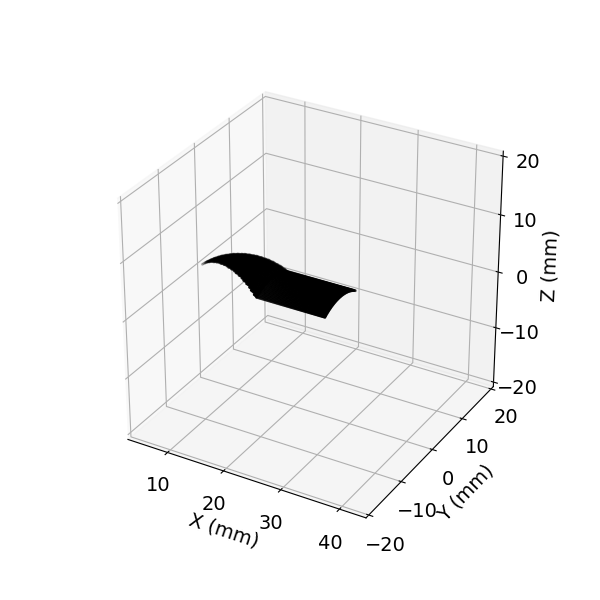

In [5]:
selected = '6mLBOPP12'
intStepSize = 0.0001 # (mm) Step size for performing integral computation

''' Get base design parameter from the condition table '''
dashLength = condiTable.loc[condiTable['CondiName']==selected,'DashLength_mm'].iloc[0]
dashSpace = condiTable.loc[condiTable['CondiName']==selected,'DashSpace_mm'].iloc[0]
infillVol = condiTable.loc[condiTable['CondiName']==selected,'Infill_mL'].iloc[0] * 1000 # Unit: mL converted to mm3

''' Find the model using the base design parameters '''
temp = pouch6Col[(pouch6Col['dashLength'] == dashLength) & (pouch6Col['dashSpace'] == dashSpace)]
mod0 = temp.iloc[(temp['totalVol']- infillVol).abs().argsort()[:1]]
print(mod0.head())

''' Ger material properties from the file '''
shellThickness = condiTable.loc[condiTable['CondiName']==selected,'ls_um'].iloc[0] / 1000 # Unit: um converted to mm
shellMaterial = condiTable.loc[condiTable['CondiName']==selected,'Shell'].iloc[0]
fluidMaterial = condiTable.loc[condiTable['CondiName']==selected,'Fluid'].iloc[0]
print("shell: %s, fluid: %s" % (shellMaterial, fluidMaterial))
epsilon_s = materProperty.loc[materProperty['Material']==shellMaterial,'DieConstant'].iloc[0]
epsilon_f = materProperty.loc[materProperty['Material']==fluidMaterial,'DieConstant'].iloc[0]

''' Compute energy step 1: Compuate capacitance of inactive state'''
# Triangle Pouch ---------------------------------------------------------------------
triPouch0 = TrianglePouch(mod0['R'].iloc[0], mod0['dashSpace'].iloc[0], mod0['dashHalfDist'].iloc[0])
triPouch0.printInfo()

triCapa = triPouch0.getCapacitance(shellThickness, epsilon_s, epsilon_f, intStepSize) # This varies by materials
print("Capacitance of inactive triangle pouch = %.3f Picofarad" % (triCapa*1e12))

# Rectangle Pouch --------------------------------------------------------------------
rectPouch0 = RectanglePouch(triPouch0.r, mod0['dashLength'].iloc[0], triPouch0.m, 2*triPouch0.m/triPouch0.dy)  
rectPouch0.transformPouch(triPouch0.triangleBottomX, 0, 0)

rectCapa = rectPouch0.getCapacitance(shellThickness, epsilon_s, epsilon_f, intStepSize) # This varies by materials
print("Capacitance of inactive rectangle pouch = %.3f Picofarad" % (rectCapa*1e12))

if False:
    fig1 = plt.figure(figsize = (6,6)) # Visualization -----------------------------------
    ax = fig1.add_subplot(111, projection='3d')
    ax.set_xlabel('X (mm)')
    ax.set_ylabel('Y (mm)')
    ax.set_zlabel('Z (mm)')
    triPouch0.displayPouch(ax, dispAdditive = True) 
    rectPouch0.displayPouch(ax, dispAdditive = True) 
    ax.set_xlim3d([triPouch0.triangleTopX, triPouch0.triangleTopX+40]); 
    ax.set_ylim3d([-20, 20]); 
    ax.set_zlim3d([-20, 20]); 
    ax.set_box_aspect([1.0, 1.0, 1.0])
    plt.show()


''' Compute energy step 2: Compuate capacitance of zipped state '''
zippedTriCapa = mod0['triArea'].iloc[0] * 1e-6 * EPSILON0 * epsilon_s / (2 * shellThickness * 1e-3)
zippedRectCapa = mod0['rectArea'].iloc[0]  * 1e-6 * EPSILON0 * epsilon_s / (2 * shellThickness * 1e-3)
print("Capacitance of fully zipped triangle cell is %f and rectangle cell is %f Picofarad" % 
      (zippedTriCapa*1e12, zippedRectCapa*1e12))

deltaTriCapa = zippedTriCapa - twoState['triCapa'].iloc[0] # Change of capacitance when fully zipped
deltaRectCapa = zippedRectCapa - twoState['rectCapa'].iloc[0] # Change of capacitance when fully zipped


In [ ]:
''' Partially zipped with fluid trapped in cells '''
diameterFullyExpanded = data['triArc'].iloc[0] * 2 / np.pi
print("Cell fully expanded with fluid has a diameter = %.3f mm" % diameterFullyExpanded)

data['oneCellExpand'] = data['triArc'] * (np.amax(pouchStructure)) + diameterFullyExpanded

data.head()
data.to_csv("ToCompareLength.csv")

In [ ]:
# fig1, ax1 = plt.subplots()
# fig1.set_size_inches(6,3)
# fig1.suptitle("Volume Check")
# ax1.set_xlabel('R (mm)')

# ax1.plot(data['R'], data['totalVol']/1000, color='tab:red')
# ax1.set_ylabel('Total Volume (mL)', color='tab:red')
# ax1.tick_params(axis='y', labelcolor='tab:red')

# ax2 = ax1.twinx() 
# ax2.plot(data['R'], data['totalCapa'], color='tab:blue')
# ax2.set_ylabel('Total Capacitance (Farad)', color='tab:blue')
# ax2.tick_params(axis='y', labelcolor='tab:blue')

# fig1.tight_layout() 


In [ ]:
# selectCondition = 'dashSpace==8.66'
# twoState = pd.concat((data.query(selectCondition).iloc[[0]], data.query(selectCondition).iloc[[-1]]), axis=0) 
# twoState.head()

In [ ]:
# ''' Zipped state '''
# zippedTriCapa = twoState['triArea'].iloc[0] * 1e-6 * EPSILON0 * epsilon_s / (2 * shellThickness * 1e-3)
# zippedRectCapa = twoState['rectArea'].iloc[0]  * 1e-6 * EPSILON0 * epsilon_s / (2 * shellThickness * 1e-3)
# print("Capacitance of fully zipped triangle cell is %f and rectangle cell is %f Picofarad" % (zippedTriCapa*1e12, zippedRectCapa*1e12))

In [ ]:
Wps = 1 # (Joule) Work done by power supply
U = 6900 # (V) Driven voltage

deltaTriCapa = zippedTriCapa - twoState['triCapa'].iloc[0] # Fully zipped capacitance
deltaRectCapa = zippedRectCapa - twoState['rectCapa'].iloc[0] # Fully zipped capacitance
# deltaTriCapa = twoState['triCapa'].iloc[1] - twoState['triCapa'].iloc[0]
# deltaRectCapa = twoState['rectCapa'].iloc[1] - twoState['rectCapa'].iloc[0]

deltaC = triNum * deltaTriCapa+ rectNum * deltaRectCapa # (Farad) Increased capacitance
deltaEs = 0.5 * U*U * deltaC
print("Change of electrostatic potential energy (Joule) = ", deltaEs)

deltaV = (twoState['totalVol'].iloc[0]) * 1e-9 # (m3) Decreased volume of fluid <- twoState['totalVol'].iloc[1]
print("Change of fluid volume (m3) = ", deltaV)

######### avgP = (Wps - deltaEs)/deltaV # This is inaccurate since power disspation is large before supplied to the actuator
avgP = deltaEs/deltaV # (2*deltaEs-deltaEs)
print("Average pressure P = %f kPa" % (avgP*1e-3))

''' Partially zipped (reality) '''
oneExpandTriNum = 2*(len(pouchStructure)-1)
oneExpandRectNum = len(pouchStructure)
partZipTriNum = triNum - oneExpandTriNum
partZipRectNum = rectNum - oneExpandRectNum
print("Partially zipped pouch (one expand per column) contains totally %d rectangle and %d triangle" % (partZipRectNum, partZipTriNum))

deltaC2 = partZipTriNum * deltaTriCapa+ partZipRectNum * deltaRectCapa # (Farad) Increased capacitance when not fully zipped
deltaEs2 = 0.5 * U*U * deltaC2
print("(Not fully zipped) Change of electrostatic potential energy (Joule) = ", deltaEs2)

oneExpandRectVol = (data['triArc'].iloc[0] * data['triArc'].iloc[0] / np.pi) * data['dashLength'].iloc[0] # Unit: mm3
#deltaV2 = deltaV - (oneExpandTriNum*twoState['triVol'].iloc[0] + oneExpandRectNum*twoState['rectVol'].iloc[0]) * 1e-9 # Unit: m3
deltaV2 = deltaV - (oneExpandTriNum*twoState['triVol'].iloc[0] + oneExpandRectNum*oneExpandRectVol) * 1e-9 # Unit: m3
print("(Not fully zipped) Change of fluid volume (m3) = ", deltaV2)

avgP2 = deltaEs2/deltaV2 # (2*deltaEs-deltaEs)
print("(Not fully zipped) Average pressure P = %f kPa" % (avgP2*1e-3))